## Instalacja bibliotek

In [33]:
# Instalacja niezbędnych bibliotek
!pip install transformers datasets accelerate scikit-learn seaborn matplotlib -q

import os
import shutil
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Importy z Hugging Face Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset

#Ustawienie urządzenia (GPU jeśli dostępne)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")
if device.type == 'cpu':
    print("⚠️ UWAGA: Brak GPU! Trening będzie trwał bardzo długo. Zmień Runtime -> Change runtime type -> T4 GPU")

Używane urządzenie: cuda


## Wczytywanie danych

In [34]:
drive.mount('/content/drive')


csv_path = '/content/drive/MyDrive/Colab Notebooks/Projekt_Transformert/1_training_data_high_quality.csv'
df = pd.read_csv(csv_path)

# Mapowanie etykiet: Modele Deep Learning wymagają liczb od 0 do N
# Zamieniamy negative, neutral, positive na: 0, 1, 2
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['Sentiment'].map(label_mapping)

# Usunięcie pustych wierszy
df = df.dropna(subset=['Comment', 'label'])
df['label'] = df['label'].astype(int)

print(f"Załadowano {len(df)} wierszy.")
df[['Comment', 'label']].head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Załadowano 18166 wierszy.


,Comment,label
0,lets not forget that apple pay in 2014 require...,1
1,here in nz 50 of retailers don’t even have con...,0
2,i will forever acknowledge this channel with t...,2
3,whenever i go to a place that doesn’t take app...,0
4,apple pay is so convenient secure and easy to ...,2


## Wizualizacja danych

/tmp/ipython-input-2722922744.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


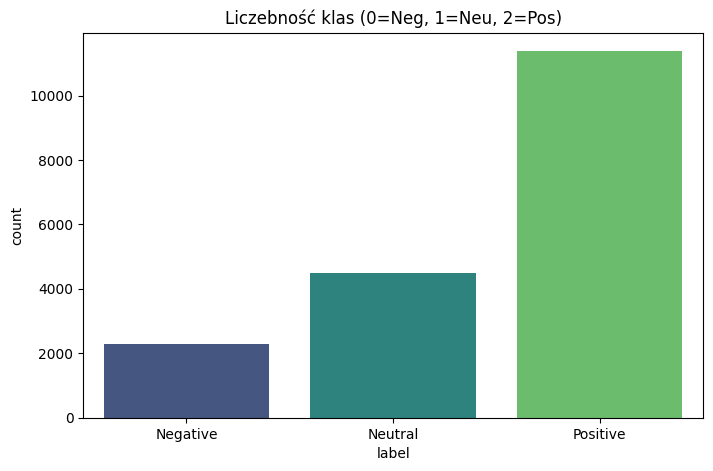

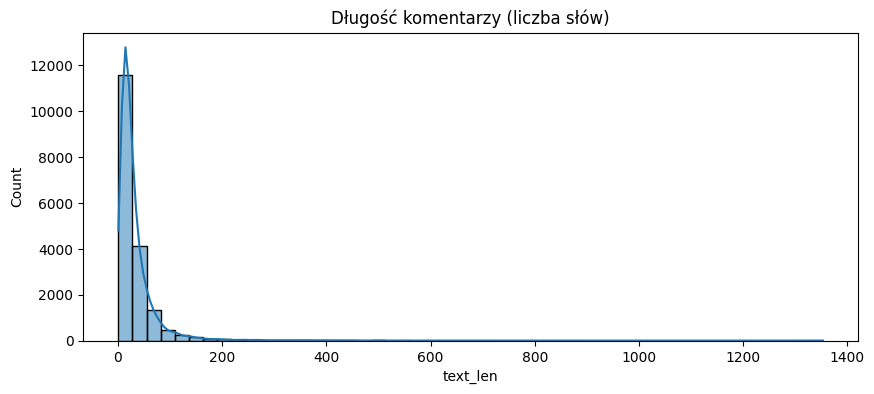

In [35]:
# Rozkład klas
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Liczebność klas (0=Neg, 1=Neu, 2=Pos)')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.show()

# Rozkład długości komentarzy (aby dobrać max_length dla modelu)
df['text_len'] = df['Comment'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 4))
sns.histplot(df['text_len'], bins=50, kde=True)
plt.title('Długość komentarzy (liczba słów)')
plt.show()

## Podział treningowe/testowe i tokenizacja

In [36]:
# 1. Podział na zbiór treningowy (80%) i walidacyjny (20%)
# Stratify zapewnia, że w obu zbiorach proporcje sentymentu są takie same
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Comment'].astype(str).tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# 2. Wybór modelu (Tutaj zmieniasz tylko nazwę, aby użyć innego!)
# Opcje:
# - "distilbert-base-uncased" (Szybki, lekki - POLECANY na start)
# - "cardiffnlp/twitter-roberta-base-sentiment-latest" (Bardzo dokładny do social media)
# - "bert-base-uncased" (Klasyk, wolniejszy)

MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
print(f"🚀 Wybrano model: {MODEL_NAME}")

# 3. Tokenizacja
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Konwersja do formatu Hugging Face Dataset
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

# Tokenizacja zbiorów
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

🚀 Wybrano model: cardiffnlp/twitter-roberta-base-sentiment-latest


Map:   0%|          | 0/14532 [00:00<?, ? examples/s]

Map:   0%|          | 0/3634 [00:00<?, ? examples/s]

## Trening modeli

In [43]:
# Definicja metryk do oceny
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

# Ładowanie czystego modelu (num_labels=3 bo mamy 3 klasy)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.to(device)

# Parametry treningu
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",  # Sprawdzaj jakość co epokę
    save_strategy="epoch",        # Zapisuj model co epokę
    load_best_model_at_end=True,  # Na koniec załaduj najlepszy model
    fp16=True,                    # Przyspieszenie na GPU (Mixed Precision)
    report_to="none"
)

# Inicjalizacja Trenera
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

print("Rozpoczynam trening...")
trainer.train()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Rozpoczynam trening...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.334100,0.392655,0.873968,0.867626
2,0.193100,0.343742,0.898734,0.898436
3,0.117400,0.501389,0.895982,0.893636


TrainOutput(global_step=2727, training_loss=0.2054116144519522, metrics={'train_runtime': 445.6473, 'train_samples_per_second': 97.826, 'train_steps_per_second': 6.119, 'total_flos': 2867673139817472.0, 'train_loss': 0.2054116144519522, 'epoch': 3.0})

## Ewaluacja

              precision    recall  f1-score   support

    Negative       0.86      0.82      0.84       459
     Neutral       0.80      0.80      0.80       898
    Positive       0.94      0.95      0.95      2277

    accuracy                           0.90      3634
   macro avg       0.87      0.86      0.86      3634
weighted avg       0.90      0.90      0.90      3634



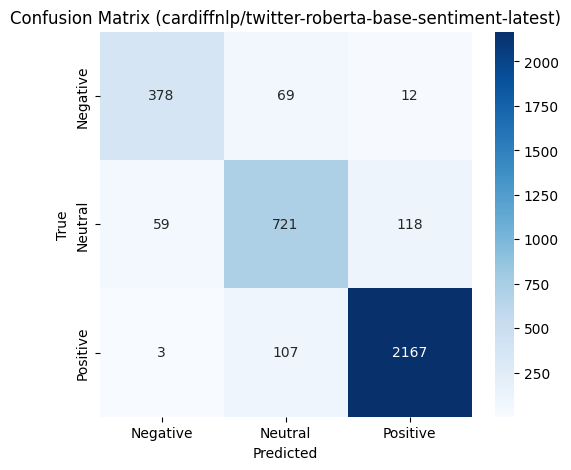

In [44]:
# Predykcja na zbiorze walidacyjnym
predictions_output = trainer.predict(tokenized_val)
preds = np.argmax(predictions_output.predictions, axis=-1)

# Raport klasyfikacji
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(val_labels, preds, target_names=target_names))

# Macierz pomyłek
cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix ({MODEL_NAME})')
plt.show()

## Wizualizacja

--- Start Generowania Wykresów ---

1. Analiza POZYTYWNA...
   ...Przetwarzanie 11383 komentarzy (Mode: Count)...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


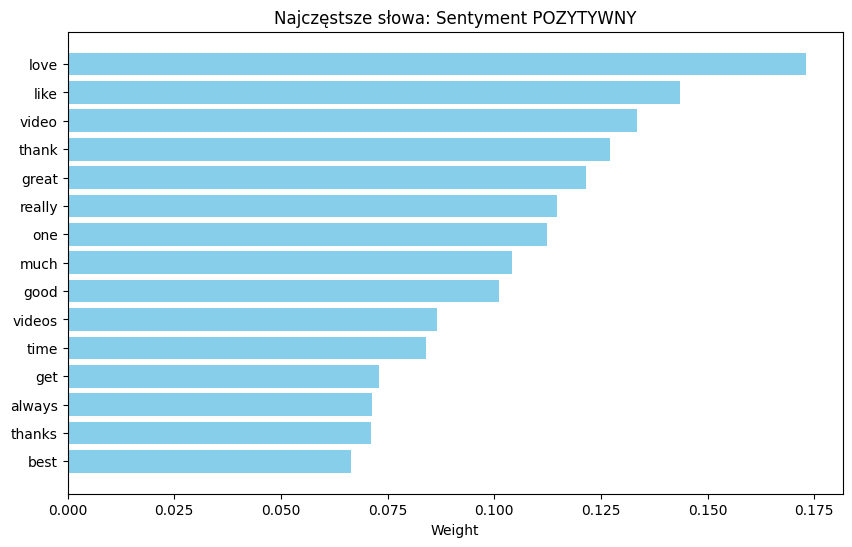

+----------------------------------------+
| Najczęstsze słowa: Sentyment POZYTYWNY |
+-------------------+--------------------+
|        Term       |       Weight       |
+-------------------+--------------------+
|        love       |       0.1730       |
|        like       |       0.1435       |
|       video       |       0.1334       |
|       thank       |       0.1270       |
|       great       |       0.1214       |
|       really      |       0.1147       |
|        one        |       0.1123       |
|        much       |       0.1042       |
|        good       |       0.1012       |
|       videos      |       0.0866       |
|        time       |       0.0841       |
|        get        |       0.0729       |
|       always      |       0.0712       |
|       thanks      |       0.0711       |
|        best       |       0.0665       |
+-------------------+--------------------+

2. Analiza NEGATYWNA...
   ...Przetwarzanie 2295 komentarzy (Mode: TF-IDF)...


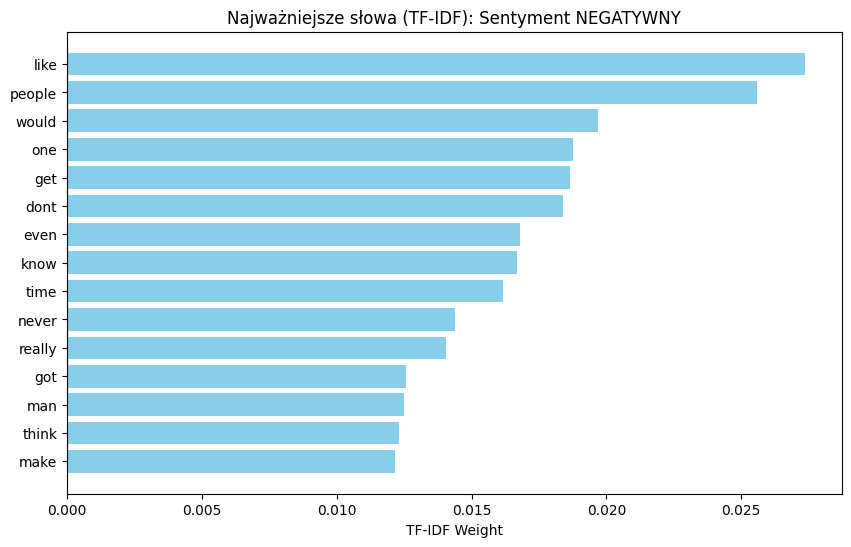

+---------------------------------------------------+
| Najważniejsze słowa (TF-IDF): Sentyment NEGATYWNY |
+----------------+----------------------------------+
|      Term      |          TF-IDF Weight           |
+----------------+----------------------------------+
|      like      |              0.0274              |
|     people     |              0.0256              |
|     would      |              0.0197              |
|      one       |              0.0188              |
|      get       |              0.0187              |
|      dont      |              0.0184              |
|      even      |              0.0168              |
|      know      |              0.0167              |
|      time      |              0.0162              |
|     never      |              0.0144              |
|     really     |              0.0141              |
|      got       |              0.0126              |
|      man       |              0.0125              |
|     think      |          

In [45]:
# ==========================================
# KROK: PRZYGOTOWANIE ŚRODOWISKA DO WIZUALIZACJI
# ==========================================
!pip install prettytable -q

import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re

# Pobieranie stop-words
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Tokenizer
def text_tokenizer(text):
    # Czyszczenie: małe litery, tylko litery, bez stop words
    text = str(text).lower()
    tokens = re.findall(r'\b[a-z]{3,}\b', text) # Tylko słowa min. 3 litery
    return [t for t in tokens if t not in stop_words]

# Funkcje pomocnicze

def aggregate_all_columns(np_matrix, aggregate_type='mean'):
    if aggregate_type == 'sum':
        return np_matrix.sum(axis=0).tolist()[0]
    elif aggregate_type == 'mean':
        return np_matrix.mean(axis=0).tolist()[0]
    raise AttributeError('Undefined aggregate type')

def sort_dict_by_values(x, desc=True):
    return dict(sorted(x.items(), key=lambda item: item[1], reverse=desc))

def create_bow_from_means_and_feature_names(means, feature_names):
    return {token: means[i] for i, token in enumerate(feature_names)}

def calculate_features_weight(X, is_tfidf_mode=True, is_binary_mode=False, aggregate_weigth_type='mean'):
    print(f"   ...Przetwarzanie {len(X)} komentarzy (Mode: {'TF-IDF' if is_tfidf_mode else 'Count'})...")
    if is_tfidf_mode:
        vectorizer = TfidfVectorizer(tokenizer=text_tokenizer, max_features=1000) # Ograniczamy cechy dla szybkosci
        X_transform = vectorizer.fit_transform(X)
    else:
        vectorizer = CountVectorizer(tokenizer=text_tokenizer, binary=is_binary_mode, max_features=1000)
        X_transform = vectorizer.fit_transform(X)

    means_for_features = aggregate_all_columns(X_transform, aggregate_weigth_type)
    bow = create_bow_from_means_and_feature_names(means_for_features, vectorizer.get_feature_names_out())
    return sort_dict_by_values(bow)

def visualize_bow_terms(bow, title, second_column_title='Weight', top_n=15):
    # Wykres
    plt.figure(figsize=(10, 6))
    keys = list(bow.keys())[:top_n]
    values = list(bow.values())[:top_n]

    plt.barh(keys, values, color='skyblue')
    plt.title(title)
    plt.xlabel(second_column_title)
    plt.gca().invert_yaxis() # Najważniejsze na górze
    plt.show()

    # Tabela
    table = PrettyTable()
    table.title = title
    table.field_names = ['Term', second_column_title]
    for k, v in zip(keys, values):
        table.add_row([k, f"{v:.4f}"])
    print(table)

# ==========================================
# URUCHOMIENIE WIZUALIZACJI
# ==========================================

# 1. Przygotowanie danych (Dopasowanie etykiet do Twojego kodu)
# Mapowanie: 0->-1 (Neg), 1->0 (Neu), 2->1 (Pos)

if 'label' in df.columns and df['label'].dtype == int:
    # Tworzymy tymczasową kolumnę do wizualizacji
    df['Vis_Sentiment'] = df['label'].map({0: -1, 1: 0, 2: 1})
else:
    # Jeśli masz oryginalną kolumnę
    df['Vis_Sentiment'] = df['Sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})

top_n = 15
TEXT_COLUMN = 'Comment'

print("--- Start Generowania Wykresów ---")

# ------------------------------------------------
# A. Sentyment POZYTYWNY (1) - Count (Liczba wystąpień)
# ------------------------------------------------
print("\n1. Analiza POZYTYWNA...")
positive_data = df.loc[df['Vis_Sentiment'] == 1][TEXT_COLUMN]

if len(positive_data) > 0:
    positive_tokens = calculate_features_weight(
        positive_data,
        is_tfidf_mode=False
    )
    visualize_bow_terms(
        positive_tokens,
        'Najczęstsze słowa: Sentyment POZYTYWNY',
        top_n=top_n
    )
else:
    print("Brak danych pozytywnych!")

# ------------------------------------------------
# B. Sentyment NEGATYWNY (-1) - TF-IDF (Ważność słowa)
# ------------------------------------------------
print("\n2. Analiza NEGATYWNA...")
negative_data = df.loc[df['Vis_Sentiment'] == -1][TEXT_COLUMN]

if len(negative_data) > 0:
    negative_tokens = calculate_features_weight(
        negative_data,
        is_tfidf_mode=True
    )
    visualize_bow_terms(
        negative_tokens,
        'Najważniejsze słowa (TF-IDF): Sentyment NEGATYWNY',
        second_column_title='TF-IDF Weight',
        top_n=top_n
    )
else:
    print("Brak danych negatywnych!")